### Including necessary Libraries

In [108]:
import re
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### Data Collection

*Tried loading the dataset using loadarff utility from scikit learn but it was failing as the original arff file contains categorical data (string values) as well and the provision to include that yet not been implemented in loadarff from scipy. So we are using custom way to read the file.*

In [109]:
pd.set_option('display.max_columns', 500, 'display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

file = open('data.arff')
columns_raw = []
data = []
for line in file:
    if any((re.match(r'@relation', line), not line.strip())):
        continue
    if re.match(r'@attribute', line):
        c_dict = {}
        c_dict["name"] = line.split(' ')[1].strip()
        c_dict["type"] = line.split(' ')[2].strip()
        columns_raw.append(c_dict)
    else:
        if line.strip != '@data':
            data.append(line.strip().split(', '))
            
df = pd.DataFrame(data=data[1:], columns=[col["name"] for col in columns_raw])
df_raw = df.copy() # saving raw data for later on additional analysis

### Exploratory Data Analysis

*1) Let's see what kind of values are there in our dataset*

In [110]:
df.head()

# Head tells us all columns but "Hour", "Vehicle_excess" and "Fire_vehicles" are numeric.

,Hour,Immobilized_bus,Broken_Truck,Vehicle_excess,Accident_victim,Running_over,Fire_vehicles,Occurrence_involving_freight,Incident_involving_dangerous_freight,Lack_of_electricity,Fire,Point_of_flooding,Manifestations,Defect_in_the_network_of_trolleybuses,Tree_on_the_road,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent
0,7:00,0.0,0.0,T,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1
1,7:30,0.0,0.0,F,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.6
2,8:00,0.0,0.0,F,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7
3,8:30,0.0,0.0,F,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2
4,9:00,0.0,0.0,F,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.1


*2) What type of values are there*

In [111]:
df.dtypes

Hour                                     object
Immobilized_bus                          object
Broken_Truck                             object
Vehicle_excess                           object
Accident_victim                          object
Running_over                             object
Fire_vehicles                            object
Occurrence_involving_freight             object
Incident_involving_dangerous_freight     object
Lack_of_electricity                      object
Fire                                     object
Point_of_flooding                        object
Manifestations                           object
Defect_in_the_network_of_trolleybuses    object
Tree_on_the_road                         object
Semaphore_off                            object
Intermittent_Semaphore                   object
Slowness_in_traffic_percent              object
dtype: object

*3) Lets see basic stats params*

In [112]:
df.describe()
# since our columns are object type doing describe won't help us a lot

,Hour,Immobilized_bus,Broken_Truck,Vehicle_excess,Accident_victim,Running_over,Fire_vehicles,Occurrence_involving_freight,Incident_involving_dangerous_freight,Lack_of_electricity,Fire,Point_of_flooding,Manifestations,Defect_in_the_network_of_trolleybuses,Tree_on_the_road,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent
count,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140,140
unique,27,4,7,3,6,5,3,2,3,5,2,6,3,6,2,5,2,83
top,16:00,0.0,0.0,F,0.0,0.0,NO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4
freq,6,104,66,128,91,124,138,139,137,130,139,132,133,118,134,125,138,5


#### Data Preparation

*1) First converting categorical columns to numerical values using pandas "category" and replacing some of the absurd values to proper one*

In [113]:
def time_float(val):
    return round(float(val.replace(':', '.')),2)

# coverting hour to float to help us creating bins later in the analysis
df["Hour"] = df["Hour"].apply(time_float)
df["Hour"] = df["Hour"].astype("category").cat.codes
df["Vehicle_excess"] = df["Vehicle_excess"].replace('f', 'F')
df[["Vehicle_excess", "Fire_vehicles"]] = df[["Vehicle_excess", "Fire_vehicles"]].astype("category")
df["Vehicle_excess"] = df["Vehicle_excess"].cat.codes
df["Fire_vehicles"] = df["Fire_vehicles"].cat.codes

In [114]:
df[["Fire_vehicles", "Vehicle_excess", "Hour"]].head()

,Fire_vehicles,Vehicle_excess,Hour
0,1,1,0
1,1,0,1
2,1,0,2
3,1,0,3
4,1,0,4


*Ok, this has now converted our categorical values to numeric one*

In [115]:
df["Running_over"].value_counts()

0.0     124
1.0      13
-1.0      1
NO        1
2.0       1
Name: Running_over, dtype: int64

In [116]:
# Running over has two absurd entries like "No" and "-1.0", converting both to 0.0  as we cann
# cannot afford lose as row because our dataset has only 140 rows
df["Running_over"] = df["Running_over"].replace('NO', 0.0)
df["Running_over"] = df["Running_over"].replace('-1.0', 0.0)

*Converting rest of the columns to float as well, to ease out further analysis*

In [117]:
df = df.apply(pd.to_numeric)
df.head()

,Hour,Immobilized_bus,Broken_Truck,Vehicle_excess,Accident_victim,Running_over,Fire_vehicles,Occurrence_involving_freight,Incident_involving_dangerous_freight,Lack_of_electricity,Fire,Point_of_flooding,Manifestations,Defect_in_the_network_of_trolleybuses,Tree_on_the_road,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent
0,0,0.0,0.0,1,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1
1,1,0.0,0.0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.6
2,2,0.0,0.0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7
3,3,0.0,0.0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2
4,4,0.0,0.0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.1


In [118]:
df.dtypes

Hour                                        int8
Immobilized_bus                          float64
Broken_Truck                             float64
Vehicle_excess                              int8
Accident_victim                          float64
Running_over                             float64
Fire_vehicles                               int8
Occurrence_involving_freight             float64
Incident_involving_dangerous_freight     float64
Lack_of_electricity                      float64
Fire                                     float64
Point_of_flooding                        float64
Manifestations                           float64
Defect_in_the_network_of_trolleybuses    float64
Tree_on_the_road                         float64
Semaphore_off                            float64
Intermittent_Semaphore                   float64
Slowness_in_traffic_percent              float64
dtype: object

*Now lets figure out if we have some missing values*

In [119]:
total = df.isnull().sum().sort_values(ascending=False)
percent1 = df.isnull().sum()/df.isnull().count()*100
percent2 = (round(percent1, 1).sort_values(ascending=False))
missing_data = pd.concat([total, percent2], axis=1, keys=["Total", '%'])
missing_data

,Total,%
Incident_involving_dangerous_freight,2,1.4
Defect_in_the_network_of_trolleybuses,2,1.4
Accident_victim,2,1.4
Semaphore_off,1,0.7
Occurrence_involving_freight,0,0.0
Immobilized_bus,0,0.0
Broken_Truck,0,0.0
Vehicle_excess,0,0.0
Running_over,0,0.0
Fire_vehicles,0,0.0


*Replacing missing values with mode of the column and normalising the data so that our values will be in the range of 0-1*

In [120]:
missing_data = missing_data[missing_data.Total > 0]
for i in missing_data.itertuples():
    freq_val = df[i.Index].mode()
    df.replace(to_replace=np.nan, value=freq_val[0], inplace=True)

In [121]:
df["Semaphore_off"].unique()

array([0., 1., 2., 4.])

In [122]:
df.isnull().sum()

Hour                                     0
Immobilized_bus                          0
Broken_Truck                             0
Vehicle_excess                           0
Accident_victim                          0
Running_over                             0
Fire_vehicles                            0
Occurrence_involving_freight             0
Incident_involving_dangerous_freight     0
Lack_of_electricity                      0
Fire                                     0
Point_of_flooding                        0
Manifestations                           0
Defect_in_the_network_of_trolleybuses    0
Tree_on_the_road                         0
Semaphore_off                            0
Intermittent_Semaphore                   0
Slowness_in_traffic_percent              0
dtype: int64

In [123]:
# Keeping copy of data before column drops, for further analysis
df_all_columns = df.copy()

*Before actually doing anything else Lets, review kind of values we have for every *
and there percentage share*
*dropping the columns having percentage share of single value greater than 95% as they won't*
*contribute much to the slowness in traffic* 

In [124]:
for column in df.columns:
    print("-----", column, "-----")
    val = df[column].value_counts()/df.shape[0]*(100)
    if val.max() > 95:
        print(f"-----Dropping the {column}")
        df.drop([column], axis=1, inplace=True)

----- Hour -----
----- Immobilized_bus -----
----- Broken_Truck -----
----- Vehicle_excess -----
-----Dropping the Vehicle_excess
----- Accident_victim -----
----- Running_over -----
----- Fire_vehicles -----
-----Dropping the Fire_vehicles
----- Occurrence_involving_freight -----
-----Dropping the Occurrence_involving_freight
----- Incident_involving_dangerous_freight -----
-----Dropping the Incident_involving_dangerous_freight
----- Lack_of_electricity -----
----- Fire -----
-----Dropping the Fire
----- Point_of_flooding -----
----- Manifestations -----
----- Defect_in_the_network_of_trolleybuses -----
----- Tree_on_the_road -----
-----Dropping the Tree_on_the_road
----- Semaphore_off -----
----- Intermittent_Semaphore -----
-----Dropping the Intermittent_Semaphore
----- Slowness_in_traffic_percent -----


In [125]:
df.columns

Index(['Hour', 'Immobilized_bus', 'Broken_Truck', 'Accident_victim',
       'Running_over', 'Lack_of_electricity', 'Point_of_flooding',
       'Manifestations', 'Defect_in_the_network_of_trolleybuses',
       'Semaphore_off', 'Slowness_in_traffic_percent'],
      dtype='object')

*Now Check if we have any outliers, using boxplot*

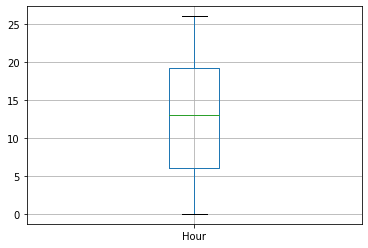

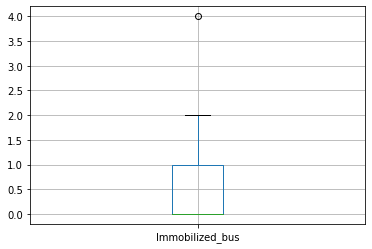

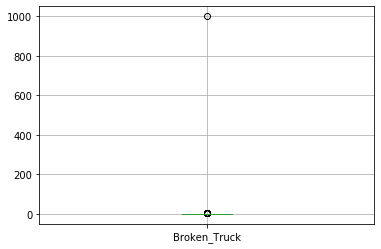

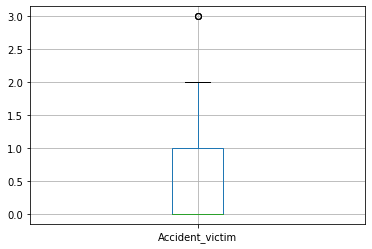

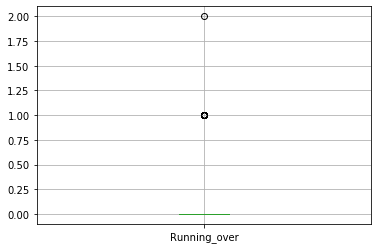

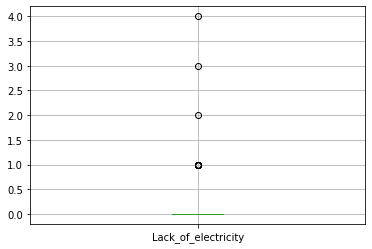

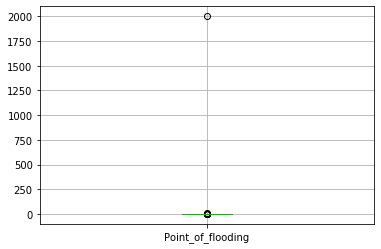

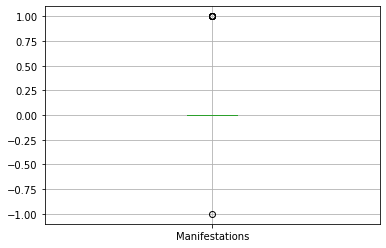

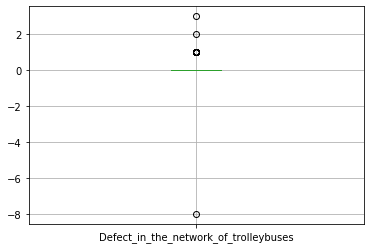

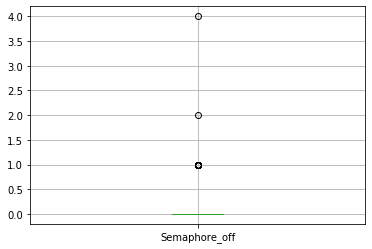

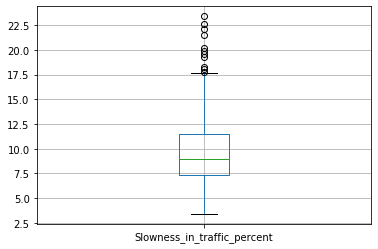

In [126]:
for column in df:
    plt.figure()
    df.boxplot([column])

*Removing the outliers as per boxplot*

In [127]:
df.drop(df[df.Broken_Truck == 1000.0].index, inplace=True)
df.drop(df[df.Point_of_flooding == 2000.0].index, inplace=True)
#df.drop(df[df.Immobilized_bus == 4.0].index, inplace=True)
#df.drop(df[df.Accident_victim == 3.0].index, inplace=True)
df.replace('', 0.0, inplace=True)
df.replace(' ', 0.0, inplace=True)
#df.drop(df[df.Slowness_in_traffic_percent > 17.5].index, inplace=True)

In [128]:
# Normalisation
minmax = MinMaxScaler()
df[[i for i in df.iloc[:, 1:]]] = minmax.fit_transform(df[[i for i in df.iloc[:, 1:]]])

*Now we are down with limited columns 11 and lets do further EDA to see what all features we*
*are important*

*Plotting the pair plot to see the direct relationship between our target variable and other 
features*

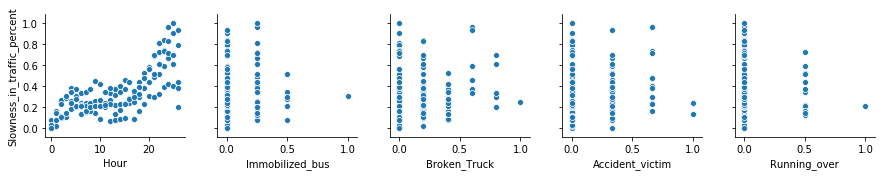

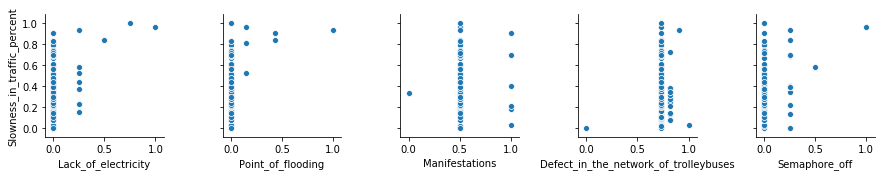

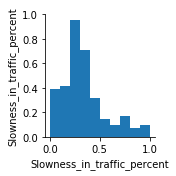

In [129]:
for i in range(0, len(df.columns), 5):
    sns.pairplot(data=df, 
                x_vars=df.columns[i:i+5],
                y_vars=["Slowness_in_traffic_percent"])

*From above plots its quite clear that "Hour" is very much in direct relation with Slowness
for specific time frame, but we can't say anything with confidence for rest of the features
Lets see individual features and see the relations the "Hour" & "Slowness in traffic"*

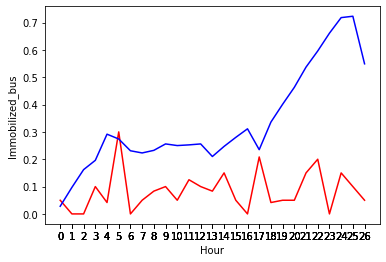

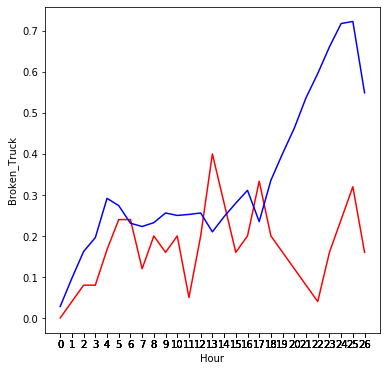

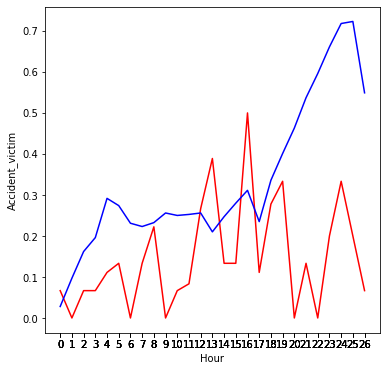

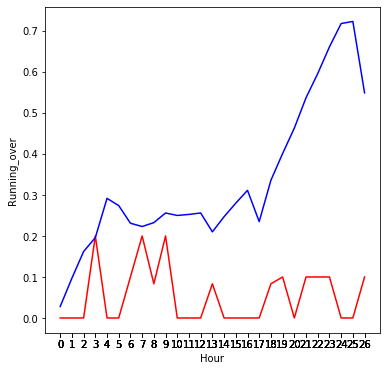

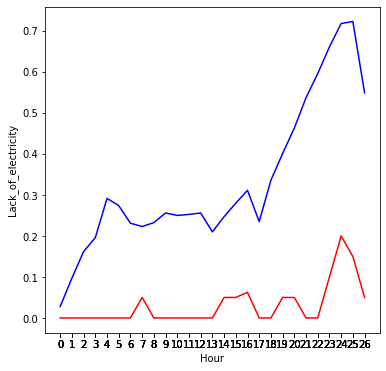

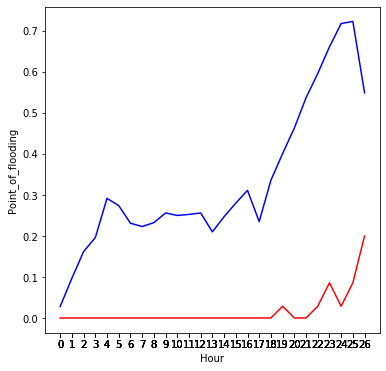

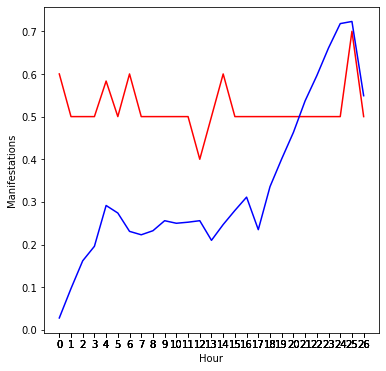

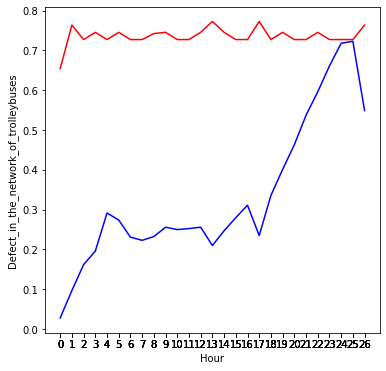

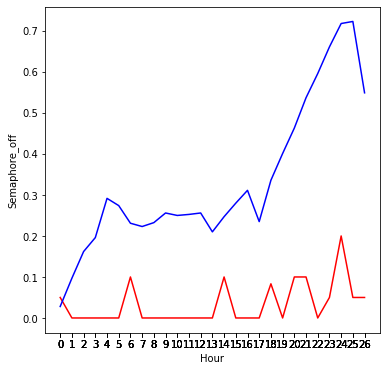

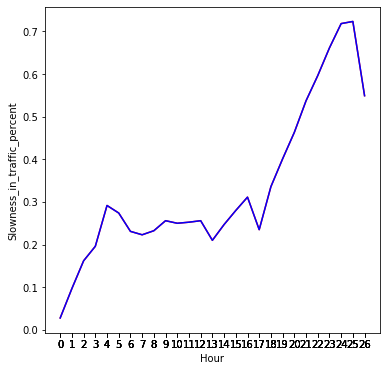

<Figure size 432x432 with 0 Axes>

In [130]:
import matplotlib.pyplot as plt
for column in df.columns:
    if column == 'Hour':
        continue
    grouped_df = df.groupby("Hour")[column]
    grouped_df_slowness = df.groupby("Hour")["Slowness_in_traffic_percent"]
    plt.plot(grouped_df.agg('mean'), label=column, color='red')
    plt.xlabel("Hour")
    plt.ylabel(column)
    plt.plot(grouped_df_slowness.agg('mean'), label="Slowness in traffic", color='blue')
    plt.xticks(df["Hour"])
    plt.figure(figsize=(6, 6))

*From our analysis we can see the below features (ordered)are contributing to Traffic Slowness*

**<font color=green>'Hour > Broken_Truck > Point_of_Flooding > Semaphore_off'</font>**

### Modelling and prediction (Cleaned and preprocessed data)

*Now lets second our analysis by running couple of models and comparing the results
First running it on the cleansed and preprocessed data*

#### Polynomial Regression

In [131]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = df["Slowness_in_traffic_percent"]
x = df.drop(["Slowness_in_traffic_percent"], axis=1)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

In [132]:
poly = PolynomialFeatures()
poly_x = poly.fit_transform(x)

regressor = LinearRegression()
regressor.fit(poly_x, y)
y_pred  = regressor.predict(poly.fit_transform(x_test))

In [133]:
print("Mean Squared Error", mse(y_test, y_pred))
errors = abs(y_pred-y_test)
print("Mean Absolute Error", round(np.mean(errors), 2))
print("R2 Score is: ", r2_score(y_test, y_pred))
print("Median Absolute Error", median_absolute_error(y_test, y_pred))

Mean Squared Error 0.007660141372908598
Mean Absolute Error 0.06
R2 Score is:  0.8675927890137374
Median Absolute Error 0.053583994923384934


In [134]:
from sklearn.feature_selection import RFE
rfe = RFE(regressor, 5)
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [False  True False  True False  True  True False  True False]
Feature Ranking: [4 1 6 1 2 1 1 5 1 3]


#### Features predicted by model using RFE

In [135]:
x_train[x_train.columns[fit.support_]].columns

Index(['Immobilized_bus', 'Accident_victim', 'Lack_of_electricity',
       'Point_of_flooding', 'Defect_in_the_network_of_trolleybuses'],
      dtype='object')

#### Random Forest Regressor

In [136]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, max_depth = 2, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('R2 Score is: ', r2_score(y_test, y_pred))
print('Median Absolute Error is: ', median_absolute_error(y_test, y_pred))

Mean Absolute Error: 0.11
R2 Score is:  0.650138644441238
Median Absolute Error is:  0.09557989167557611


In [137]:
from sklearn.feature_selection import RFE
rfe = RFE(rf, 5)
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [ True False False  True False  True  True False False  True]
Feature Ranking: [1 6 2 1 5 1 1 4 3 1]


*Columns influencing slowness in traffic as per RandomForest Regressor*

In [138]:
x_train[x_train.columns[fit.support_]].columns

Index(['Hour', 'Accident_victim', 'Lack_of_electricity', 'Point_of_flooding',
       'Semaphore_off'],
      dtype='object')

### Modelling and prediction (on Raw data)

*Now lets second our analysis by running couple of models and comparing the results
First running it on raw data*

In [139]:
df_all_columns.drop(df_all_columns[df_all_columns.Broken_Truck == 1000.0].index, inplace=True)
df_all_columns.drop(df_all_columns[df_all_columns.Point_of_flooding == 2000.0].index, inplace=True)
#df.drop(df[df.Immobilized_bus == 4.0].index, inplace=True)
#df.drop(df[df.Accident_victim == 3.0].index, inplace=True)
df_all_columns.replace('', 0.0, inplace=True)
df_all_columns.replace(' ', 0.0, inplace=True)
#df.drop(df[df.Slowness_in_traffic_percent > 17.5].index, inplace=True)
# Normalisation
minmax = MinMaxScaler()
df_all_columns[[i for i in df_all_columns.iloc[:, 1:]]] = minmax.fit_transform(df_all_columns[[i for i in df_all_columns.iloc[:, 1:]]])

y = df_all_columns["Slowness_in_traffic_percent"]
x = df_all_columns.drop(["Slowness_in_traffic_percent"], axis=1)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

In [140]:
poly = PolynomialFeatures()
poly_x = poly.fit_transform(x)

regressor = LinearRegression()
regressor.fit(poly_x, y)
y_pred  = regressor.predict(poly.fit_transform(x_test))

print("Mean Squared Error", mse(y_test, y_pred))
errors = abs(y_pred-y_test)
print("Mean Absolute Error", round(np.mean(errors), 2))
print("R2 Score is: ", r2_score(y_test, y_pred))
print("Median Absolute Error", median_absolute_error(y_test, y_pred))

Mean Squared Error 0.008451120865720856
Mean Absolute Error 0.08
R2 Score is:  0.8539205363108043
Median Absolute Error 0.07067016601562497


In [141]:
from sklearn.feature_selection import RFE
rfe = RFE(regressor, 5)
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [False False False False False False  True False False  True False  True
  True  True False False False]
Feature Ranking: [ 8  5 11 13  3  7  1  2  9  1  4  1  1  1 12  6 10]


In [142]:
x_train[x_train.columns[fit.support_]].columns

Index(['Fire_vehicles', 'Lack_of_electricity', 'Point_of_flooding',
       'Manifestations', 'Defect_in_the_network_of_trolleybuses'],
      dtype='object')

#### Random Forest Regressor

In [143]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, max_depth = 2, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('R2 Score is: ', r2_score(y_test, y_pred))
print('Median Absolute Error is: ', median_absolute_error(y_test, y_pred))

Mean Absolute Error: 0.11
R2 Score is:  0.6557220564722539
Median Absolute Error is:  0.09604773184452466


In [144]:
from sklearn.feature_selection import RFE
rfe = RFE(rf, 5)
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [ True False  True False False False False False False  True False  True
 False False False  True False]
Feature Ranking: [ 1  2  1 12  3  4 11  6 13  1 10  1  9  8  5  1  7]


In [145]:
x_train[x_train.columns[fit.support_]].columns

Index(['Hour', 'Broken_Truck', 'Lack_of_electricity', 'Point_of_flooding',
       'Semaphore_off'],
      dtype='object')

## Additional analysis

*We can somehow enhance the model performance by bucketizing the hour column*

In [146]:
b = [0, 9, 10, 18, 26]
l = ["Morning", "Afternoon", "Evening", "Night"]
df["Time"] = pd.cut(df["Hour"], bins=b, labels=l)
x = pd.get_dummies(df["Time"])
df = pd.concat([df, x], axis=1)
df = df.drop(["Time"], axis=1)

y = df["Slowness_in_traffic_percent"]
x = df.drop(["Slowness_in_traffic_percent"], axis=1)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

In [147]:
poly = PolynomialFeatures()
poly_x = poly.fit_transform(x)

regressor = LinearRegression()
regressor.fit(poly_x, y)
y_pred  = regressor.predict(poly.fit_transform(x_test))

In [148]:
print("Mean Squared Error", mse(y_test, y_pred))
errors = abs(y_pred-y_test)
print("Mean Absolute Error", round(np.mean(errors), 2))
print("R2 Score is: ", r2_score(y_test, y_pred))
print("Median Absolute Error", median_absolute_error(y_test, y_pred))

Mean Squared Error 0.0031587940797392676
Mean Absolute Error 0.04
R2 Score is:  0.9453995567683128
Median Absolute Error 0.036048965454101536


*From our analysis we can see the below features are contributing to Traffic Slowness*
and Second by model also :)*
**<font color=green>'Hour : Broken_Truck : Point_of_Flooding : Semaphore_off'</font>**